In [25]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np

region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
stores_key = 'stores.csv'
transactions_key = 'transactions.csv'


store = 's3://{}/{}/{}'.format(bucket, prefix, stores_key)
transaction = 's3://{}/{}/{}'.format(bucket, prefix, transactions_key)

stores = pd.read_csv(store)
transactions = pd.read_csv(transaction)

region

'eu-west-2'

In [26]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [27]:
stores = transactions.merge(stores)


stores['date'] = pd.to_datetime(stores['date'])
stores['month'] = stores['date'].dt.month
stores['year'] = stores['date'].dt.year
stores['week'] = stores['date'].dt.week
stores['day'] = stores['date'].dt.day

stores

/tmp/ipykernel_30366/1330265988.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  stores['week'] = stores['date'].dt.week


,date,store_nbr,transactions,city,state,type,cluster,month,year,week,day
0,2013-01-01,25,770,Salinas,Santa Elena,D,1,1,2013,1,1
1,2013-01-02,25,1038,Salinas,Santa Elena,D,1,1,2013,1,2
2,2013-01-03,25,887,Salinas,Santa Elena,D,1,1,2013,1,3
3,2013-01-04,25,1054,Salinas,Santa Elena,D,1,1,2013,1,4
4,2013-01-05,25,1355,Salinas,Santa Elena,D,1,1,2013,1,5
...,...,...,...,...,...,...,...,...,...,...,...
83483,2017-08-11,52,2957,Manta,Manabi,A,11,8,2017,32,11
83484,2017-08-12,52,2804,Manta,Manabi,A,11,8,2017,32,12
83485,2017-08-13,52,2433,Manta,Manabi,A,11,8,2017,32,13
83486,2017-08-14,52,2074,Manta,Manabi,A,11,8,2017,33,14


# EDA

In [ ]:
plt.figure(figsize=(10,6))

sns.pairplot(data=stores)

In [13]:
corr = stores.corr()
corr

/tmp/ipykernel_30366/155214244.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stores.corr()


,store_nbr,transactions,cluster,month,year,week,day
store_nbr,1.000000,0.189311,-0.078323,0.003649,0.016848,0.004348,-0.000190
transactions,0.189311,1.000000,0.196014,0.037838,-0.037086,0.027368,-0.020544
cluster,-0.078323,0.196014,1.000000,-0.000089,-0.014887,-0.000467,0.000392
month,0.003649,0.037838,-0.000089,1.000000,-0.151364,0.977354,-0.008214
year,0.016848,-0.037086,-0.014887,-0.151364,1.000000,-0.151970,-0.011118
week,0.004348,0.027368,-0.000467,0.977354,-0.151970,1.000000,0.057576
day,-0.000190,-0.020544,0.000392,-0.008214,-0.011118,0.057576,1.000000


<AxesSubplot: >

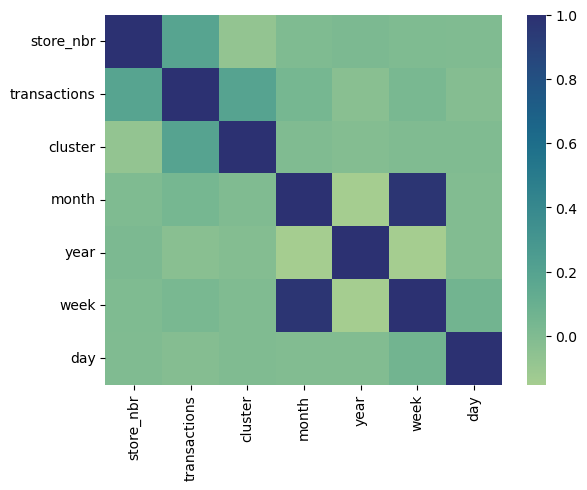

In [14]:
sns.heatmap(data=corr, cmap='crest')

<AxesSubplot: xlabel='transactions', ylabel='Count'>

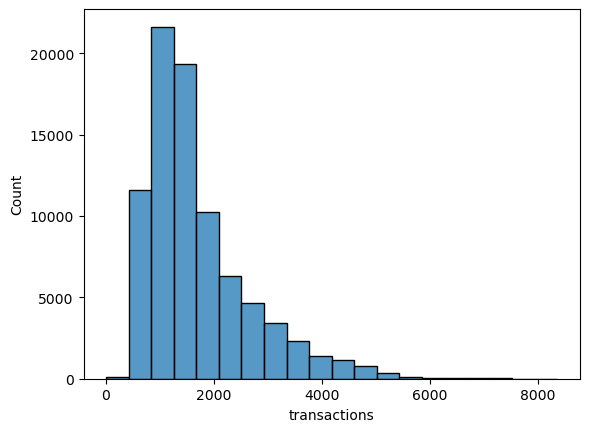

In [15]:
sns.histplot(stores['transactions'], bins=20)

<AxesSubplot: xlabel='city', ylabel='transactions'>

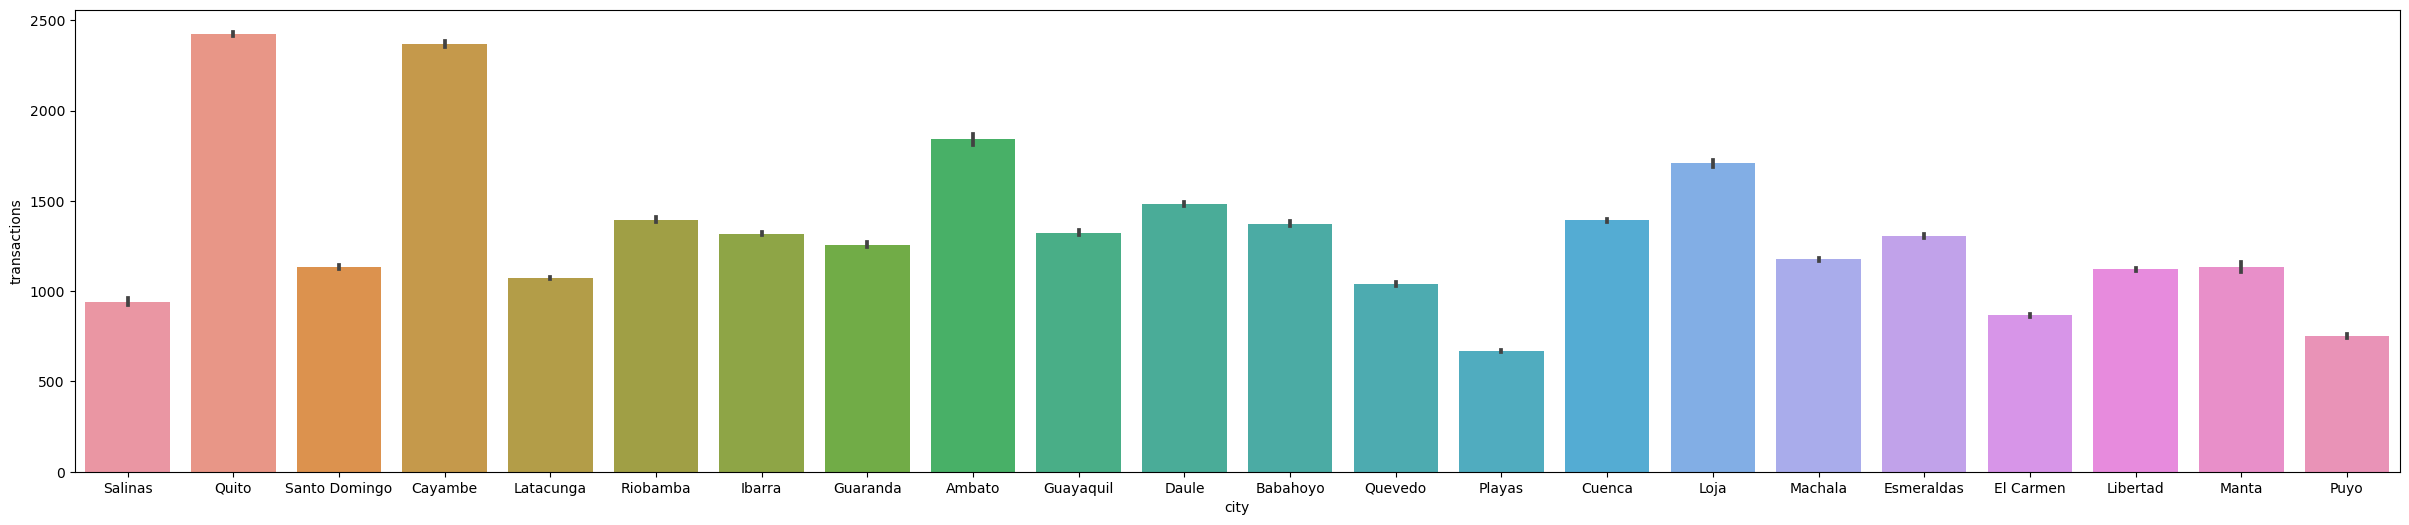

In [16]:
plt.figure(figsize=(30,6))

sns.barplot(data=stores, x='city', y='transactions')

<AxesSubplot: xlabel='state', ylabel='transactions'>

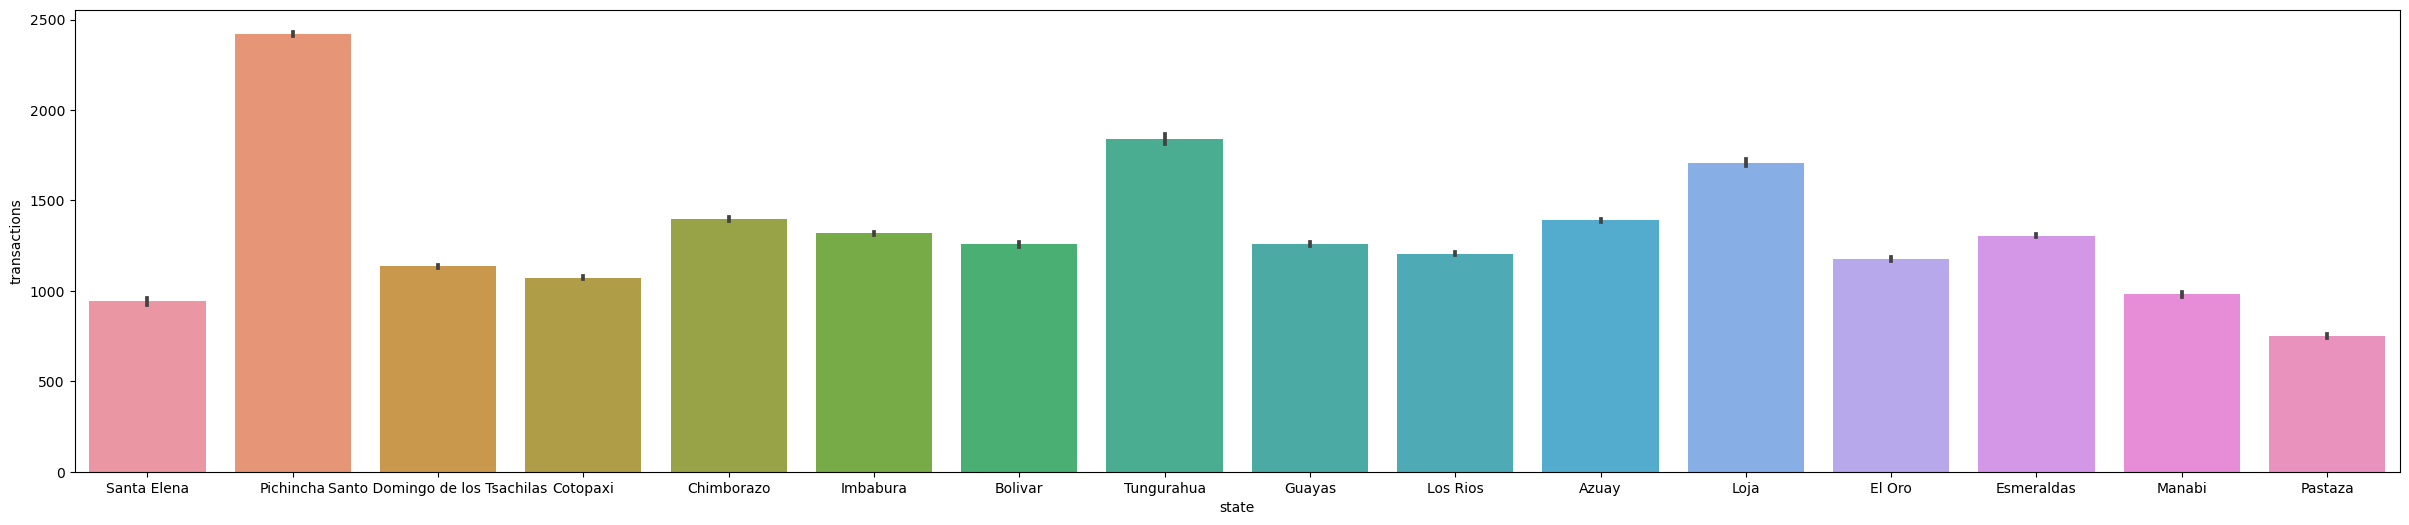

In [17]:
plt.figure(figsize=(30,6))

sns.barplot(data=stores, x='state', y='transactions')

<AxesSubplot: ylabel='transactions'>

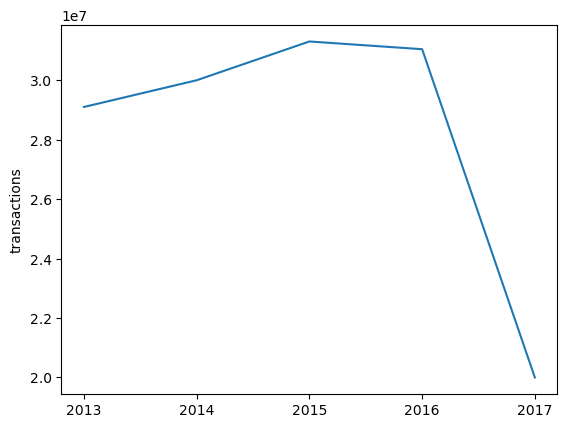

In [18]:
months = stores.month.unique()

transaction_per_week = stores.groupby('week')['transactions'].sum()
transaction_per_month = stores.groupby('month')['transactions'].sum()
transaction_per_year = stores.groupby('year')['transactions'].sum()

sns.lineplot(x=stores['year'].unique().astype(str), y=transaction_per_year)

<AxesSubplot: ylabel='transactions'>

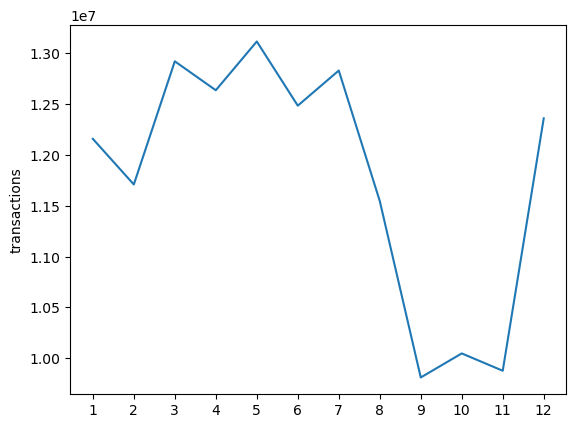

In [19]:
sns.lineplot(x=stores['month'].unique().astype(str), y=transaction_per_month)

<AxesSubplot: ylabel='transactions'>

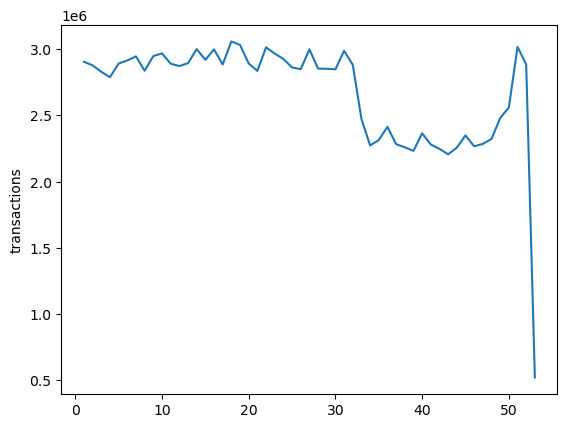

In [20]:
sns.lineplot(x=stores['week'].unique(), y=transaction_per_week)

<AxesSubplot: xlabel='day', ylabel='transactions'>

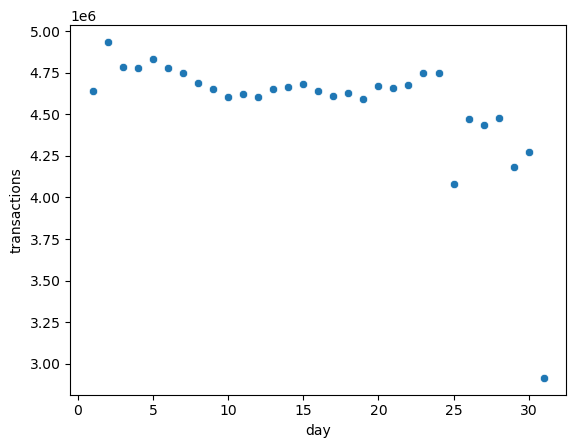

In [22]:
stores['day'] = pd.DatetimeIndex(stores['date']).day

transaction_by_day = stores.groupby('day')['transactions'].sum()

sns.scatterplot(transaction_by_day)

# Cleaning

In [23]:
target = stores['transactions']
stores = stores.drop('transactions', axis = 1)
stores = stores.drop('date', axis=1)
stores = stores.drop('store_nbr', axis=1)

stores = pd.concat([target, stores], axis = 1)
stores

,transactions,city,state,type,cluster,month,year,week,day
0,770,Salinas,Santa Elena,D,1,1,2013,1,1
1,2111,Quito,Pichincha,D,13,1,2013,1,2
2,2358,Quito,Pichincha,D,13,1,2013,1,2
3,3487,Quito,Pichincha,D,8,1,2013,1,2
4,1922,Quito,Pichincha,D,9,1,2013,1,2
...,...,...,...,...,...,...,...,...,...
83483,2804,Ambato,Tungurahua,A,14,8,2017,33,15
83484,1573,Guayaquil,Guayas,A,17,8,2017,33,15
83485,2255,Manta,Manabi,A,11,8,2017,33,15
83486,932,Manta,Manabi,D,13,8,2017,33,15


In [24]:
city = pd.get_dummies(stores['city'])
#states = pd.get_dummies(stores['state'])
types = pd.get_dummies(stores['type'])
#month = pd.get_dummies(stores['month'])
#year = pd.get_dummies(stores['year'])
cluster = pd.get_dummies(stores['cluster'])

stores = pd.concat([stores, city], axis=1)
#stores = pd.concat([stores, states], axis=1)
stores = pd.concat([stores, types], axis=1)
#stores = pd.concat([stores, month], axis=1)
#stores = pd.concat([stores, year], axis=1)
stores = pd.concat([stores, cluster], axis=1)

stores = stores.drop(['city', 'state', 'type', 'cluster'], axis=1)
stores

,transactions,month,year,week,day,Ambato,Babahoyo,Cayambe,Cuenca,Daule,...,8,9,10,11,12,13,14,15,16,17
0,770,1,2013,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2111,1,2013,1,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2358,1,2013,1,2,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3487,1,2013,1,2,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,1922,1,2013,1,2,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83483,2804,8,2017,33,15,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
83484,1573,8,2017,33,15,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
83485,2255,8,2017,33,15,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
83486,932,8,2017,33,15,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [14]:
train_data, validation_data, test_data = np.split(
    stores.sample(frac=1, random_state=1729),
    [int(0.7 * len(stores)), int(0.9 * len(stores))],
)
train_data.to_csv("train.csv", header=False, index=False)
validation_data.to_csv("validation.csv", header=False, index=False)

train_data

,transactions,Ambato,Babahoyo,Cayambe,Cuenca,Daule,El Carmen,Esmeraldas,Guaranda,Guayaquil,...,8,9,10,11,12,13,14,15,16,17
36241,2003,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
78460,586,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
54265,1528,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
35537,2897,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
65595,4758,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58237,1136,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25551,1408,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
15936,2070,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40440,902,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [15]:
bucket = sagemaker.Session().default_bucket()
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')

In [16]:
bucket

'sagemaker-eu-west-2-866647877267'

In [17]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, "1.5-1")

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

In [18]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    verbosity=0,
    objective="reg:squarederror",
    num_round=100,
)

xgb.fit({"train": s3_input_train, "validation": s3_input_validation})

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-03-16-11-42-40-490


2023-03-16 11:42:40 Starting - Starting the training job...
2023-03-16 11:43:11 Starting - Preparing the instances for training............
2023-03-16 11:45:12 Downloading - Downloading input data......
2023-03-16 11:45:43 Training - Downloading the training image...
2023-03-16 11:46:23 Training - Training image download completed. Training in progress..[2023-03-16 11:46:40.697 ip-10-0-86-74.eu-west-2.compute.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-03-16 11:46:40.781 ip-10-0-86-74.eu-west-2.compute.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2023-03-16:11:46:41:INFO] Imported framework sagemaker_xgboost_container.training
[2023-03-16:11:46:41:INFO] Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
[2023-03-16:11:46:41:INFO] No GPUs detected (normal if no gpus installed)
[2023-03-16:11:46:41:INFO] Running XGBoost Sagemaker in algorithm mode
[2023-03-16:11:46:41:INFO] Determin

In [19]:
from sagemaker.serializers import CSVSerializer

xgb_predictor = xgb.deploy(
    initial_instance_count=1, instance_type="ml.m4.xlarge", serializer=CSVSerializer()
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2023-03-16-11-47-25-188
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2023-03-16-11-47-25-188
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2023-03-16-11-47-25-188


------!

In [20]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = "".join([predictions, xgb_predictor.predict(array).decode("utf-8")])

    return predictions.split("\n")[:-1]

predictions = predict(test_data.values[:, 1:])
predictions

['1700.89111328125',
 '2495.9892578125',
 '1065.4232177734375',
 '1498.09326171875',
 '756.9893188476562',
 '3351.318115234375',
 '912.6353759765625',
 '1767.8775634765625',
 '1697.1689453125',
 '2434.146728515625',
 '1456.093017578125',
 '1803.8074951171875',
 '2047.76220703125',
 '954.02197265625',
 '768.6753540039062',
 '1270.644287109375',
 '4251.6552734375',
 '3461.835205078125',
 '1205.64697265625',
 '1205.64697265625',
 '1165.4158935546875',
 '2050.660888671875',
 '1786.95458984375',
 '632.312255859375',
 '1444.0421142578125',
 '1157.09716796875',
 '1758.1424560546875',
 '1448.8017578125',
 '965.927734375',
 '1232.514404296875',
 '1340.324951171875',
 '761.055419921875',
 '1873.341796875',
 '722.7470092773438',
 '1719.8897705078125',
 '675.7556762695312',
 '782.5811767578125',
 '2608.542724609375',
 '1360.8673095703125',
 '566.4595947265625',
 '1269.20556640625',
 '2480.230224609375',
 '4231.91064453125',
 '3304.1474609375',
 '1098.5816650390625',
 '3206.328857421875',
 '2125.27

In [44]:
from sklearn.metrics import mean_absolute_error, r2_score
predictions = np.array(predictions, dtype=float)
mae_score = mean_absolute_error(test_data['transactions'], predictions)
r2 = r2_score(test_data['transactions'], predictions)
print("The Mean Absolute Error of our Model is {}".format(round(score, 2)))
print("The R^2 Error of our Model is {}".format(round(r2, 2)))

The Mean Absolute Error of our Model is 253.83
The R^2 Error of our Model is 0.84


In [41]:
tuning_job_config = {
    "ParameterRanges": {
      "ContinuousParameterRanges": [
        {
          "MaxValue": "1",
          "MinValue": "0",
          "Name": "eta"
        },
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "min_child_weight"
        }
      ],
      "IntegerParameterRanges": [
        {
          "MaxValue": "10",
          "MinValue": "1",
          "Name": "max_depth"
        }
      ]
    },
    "ResourceLimits": {
      "MaxNumberOfTrainingJobs": 20,
      "MaxParallelTrainingJobs": 3
    },
    "Strategy": "Bayesian",
    "HyperParameterTuningJobObjective": {
      "MetricName": "validation:mae",
      "Type": "Minimize"
    },
    "RandomSeed" : 123
  }

In [42]:
s3_input_train = 's3://{}/{}/train'.format(bucket, prefix)
s3_input_validation ='s3://{}/{}/validation/'.format(bucket, prefix)

training_job_definition = {
    "AlgorithmSpecification": {
      "TrainingImage": container,
      "TrainingInputMode": "File"
    },
    "InputDataConfig": [
      {
        "ChannelName": "train",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_train
          }
        }
      },
      {
        "ChannelName": "validation",
        "CompressionType": "None",
        "ContentType": "csv",
        "DataSource": {
          "S3DataSource": {
            "S3DataDistributionType": "FullyReplicated",
            "S3DataType": "S3Prefix",
            "S3Uri": s3_input_validation
          }
        }
      }
    ],
    "OutputDataConfig": {
      "S3OutputPath": "s3://{}/{}/output".format(bucket,prefix)
    },
    "ResourceConfig": {
      "InstanceCount": 1,
      "InstanceType": "ml.m4.xlarge",
      "VolumeSizeInGB": 10
    },
    "RoleArn": role,
    "StaticHyperParameters": {
      "eval_metric": "mae",
      "num_round": "100",
      "objective": "reg:squarederror",
      "rate_drop": "0.3",
      "tweedie_variance_power": "1.4"
    },
    "StoppingCondition": {
      "MaxRuntimeInSeconds": 43200
    }
}

In [50]:
smclient = boto3.Session().client('sagemaker')
tuning_job_name = "DS-CHALLE4"
tuner = smclient.create_hyper_parameter_tuning_job(HyperParameterTuningJobName = tuning_job_name,
                                           HyperParameterTuningJobConfig = tuning_job_config,
                                           TrainingJobDefinition = training_job_definition)


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


{'TrainingJobName': 'DS-CHALLE4-002-6888a7ba',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-2:866647877267:training-job/DS-CHALLE4-002-6888a7ba',
 'CreationTime': datetime.datetime(2023, 3, 16, 12, 44, 4, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2023, 3, 16, 12, 45, 36, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2023, 3, 16, 12, 47, 28, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Completed',
 'TunedHyperParameters': {'eta': '0.2513529496050715',
  'max_depth': '5',
  'min_child_weight': '6.501753251206771'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
  'Value': 244.7217559814453},
 'ObjectiveStatus': 'Succeeded'}

In [ ]:
best_overall_training_job = smclient.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuning_job_name
)["BestTrainingJob"]

best_overall_training_job

In [ ]:
xgb_predictor.delete_model()
xgb_predictor.delete_endpoint()